# Overlay Satellite Imagery with Contours

In order to successfully make a plot with satellite data and contours we'll need to use two data sources to bring in the data and then set the plot parameters for each. Some key elements to keep in mind:
1. The time of your satellite file likely won't be the same as the contour data.
   - This is because we get updated satellite data every 5 minutes while model analysis files are only available at 00, 06, 12, and 18 UTC.
   - Create two different time variables to help keep track of the different times.
2. You'll need to keep two separate variables for the data objects, one for the satellite data and one for the gridded data.
   - It doesn't matter what you call the variable names, for example you can store the satellite data in `ds` and the gridded data in `ds_gfs` if you are using GFS gridded analyses.
3. Pay attention to the data and time attributes for the different data plots to make sure you assign the correct variables to each.

### Import Packages

In [2]:
from datetime import datetime

import metpy.calc as mpcalc
from metpy.plots import declarative
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

### Helper Function

In [3]:
def get_satellite_file_url(datasets, date):
    '''A function to help find the desired satellite data based on the time given.
    
    Input:
     - List of datasets from a THREDDS Catalog
     - Date of desired dataset (datetime object)
     
    Output:
     - Index value of dataset closest to desired time
    '''
    sat_date_hour = date.strftime('%Y%j%H')
    files = []
    times = []
    for file in cat.datasets:
        if sat_date_hour in file:
            times.append(datetime.strptime(file.split('_')[3][1:-3], '%Y%j%H%M'))
            files.append(file)
    find_file = np.abs(np.array(times) - date)
    return list(cat.datasets).index(files[np.argmin(find_file)])

### Get Satellite Data


In [7]:
date = datetime(2022, 5, 4, 12, 0)

# Create variables for URL generation
region = 'CONUS'
channel = 9
satellite = 'east'

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string
data_url = (f'https://thredds.ucar.edu/thredds/catalog/satellite/goes/{satellite}/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
            f'{date:%Y%m%d}/catalog.xml')

# Get list of files available for particular day
cat = TDSCatalog(data_url)

# Use homemade function to get dataset for desired time
dataset = cat.datasets[get_satellite_file_url(cat.datasets, date)]

# Open most recent file available
ds = dataset.remote_access(use_xarray=True)

# Apply a square root correction for visible imagery only
if channel == 2:
    ds['Sectorized_CMI'].values = np.sqrt(ds['Sectorized_CMI'].values)

# Grab time from file and make into datetime object for plotting and later data access
vtime = ds.time.values.astype('datetime64[ms]').astype('O')

### Get Gridded Data
Choose the closest time to the satellite observations based on the limitations of available gridded data. For example, GFS analysis are only available at 00, 06, 12, and 18 UTC. So for a satellite observation from 1530 UTC, the closest gridded ouput that would be availabe would be 12 UTC.

In [8]:
gfs_date = datetime(2022, 5, 4, 12)

# Remote access to the dataset from the UCAR site
ds_gfs = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib'
                         f'/NCEP/GFS/Global_onedeg/GFS_Global_onedeg_{gfs_date:%Y%m%d}_{gfs_date:%H%M}.grib2')

# Subset data to be just over the U.S. for plotting purposes
ds_gfs = ds_gfs.sel(lat=slice(70,10), lon=slice(360-150, 360-55)).metpy.parse_cf()

### Plot Imagery

Set attributes for both the contour and satellite image plots, then add both to the same panel.

Note: The extent is set by hand to better correspond to the satellite image area. Trial and error is the best way to come up with an area attribute setting that would best.

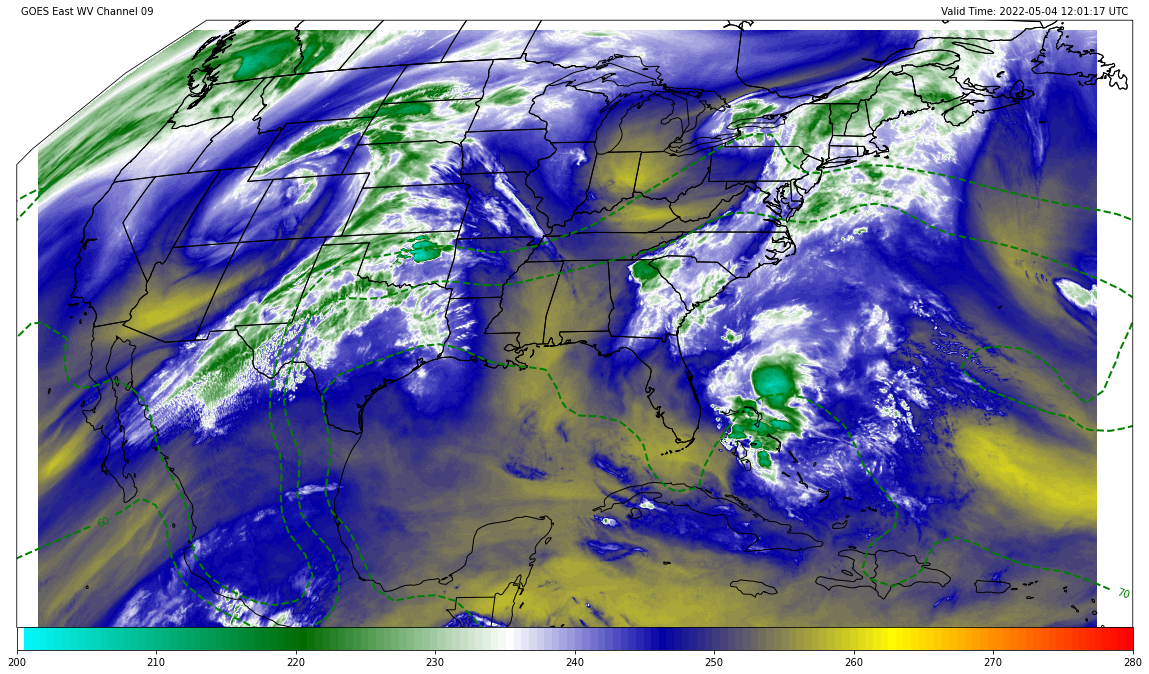

In [12]:


    tmpk = ds_gfs.Temperature_isobaric.metpy.sel(vertical=300*units.hPa, time=gfs_date)
    uwind = ds_gfs['u-component_of_wind_isobaric'].metpy.sel(vertical=300*units.hPa, time=gfs_date)
    vwind = ds_gfs['v-component_of_wind_isobaric'].metpy.sel(vertical=300*units.hPa, time=gfs_date)
    ds_gfs['wind_speed_isobaric'] = mpcalc.wind_speed(uwind, vwind)

    cntr = declarative.ContourPlot()
    cntr.data = ds_gfs
    cntr.field = 'Dewpoint_temperature_height_above_ground'
    cntr.level = 2 * units.m
    cntr.time = gfs_date
    cntr.linecolor = 'green'
    cntr.linestyle = 'dashed'
    cntr.contours = list(range(50, 171, 10))
    cntr.clabels = True
    cntr.plot_units = 'degF'
    cntr.smooth_field = 3

    img = declarative.ImagePlot()
    img.data = ds
    img.field = 'Sectorized_CMI'
    img.colormap = 'WVCIMSS_r'
    img.colorbar = 'horizontal'
    img.image_range = (200, 280)

    # Plot the data on a map
    panel = declarative.MapPanel()
    panel.area = [-115, -60, 17, 52]
    panel.layers = ['coastline', 'borders', 'states']
    panel.title = f"{f'GOES East WV Channel {channel:02d}':<155}{f'Valid Time: {vtime} UTC':>155}"
    panel.plots = [img, cntr]

    # Place the map on a figure
    pc = declarative.PanelContainer()
    pc.size = (20, 16)
    pc.panels = [panel]
    
    pc.show()


In [6]:
ds_gfs

<xarray.Dataset>
Dimensions:                                                                     (time1: 128, time1_bounds_1: 2, time3: 254, time3_bounds_1: 2, height_above_ground_layer: 1, height_above_ground_layer_bounds_1: 2, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, pressure_difference_layer: 1, pressure_difference_layer_bounds_1: 2, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, sigma_layer: 4, sigma_layer_bounds_1: 2, pressure_difference_layer2: 3, pressure_difference_layer2_bounds_1: 2, lat: 61, lon: 96, time: 129, isobaric1: 41, height_above_ground: 1, isobaric: 22, hybrid1: 1, time2: 128, potential_vorticity_surface: 2, altitude_above_msl1: 1, sigma: 1, height_above_ground2: 1, height_above_ground1: 2, altitude_above_msl: 3, height_above_ground5: 3, hybrid: 2, height_above_ground3: 2, height_above_ground4: 7)
Coordinates: (12/29)
    reftime                                                                     datetime64[ns] ...
  * time1                                                                       (time1) datetime64[ns] ...
  * time3                                                                       (time3) datetime64[ns] ...
  * height_above_ground_layer                                                   (height_above_ground_layer) float32 ...
  * depth_below_surface_layer                                                   (depth_below_surface_layer) float32 ...
  * pressure_difference_layer                                                   (pressure_difference_layer) float32 ...
    ...                                                                          ...
  * height_above_ground1                                                        (height_above_ground1) float32 ...
  * altitude_above_msl                                                          (altitude_above_msl) float32 ...
  * height_above_ground5                                                        (height_above_ground5) float32 ...
  * hybrid                                                                      (hybrid) float32 ...
  * height_above_ground3                                                        (height_above_ground3) float32 ...
  * height_above_ground4                                                        (height_above_ground4) float32 ...
Dimensions without coordinates: time1_bounds_1, time3_bounds_1, height_above_ground_layer_bounds_1, depth_below_surface_layer_bounds_1, pressure_difference_layer_bounds_1, height_above_ground_layer1_bounds_1, pressure_difference_layer1_bounds_1, sigma_layer_bounds_1, pressure_difference_layer2_bounds_1
Data variables: (12/180)
    LatLon_Projection                                                           int32 ...
    time1_bounds                                                                (time1, time1_bounds_1) datetime64[ns] ...
    time3_bounds                                                                (time3, time3_bounds_1) datetime64[ns] ...
    height_above_ground_layer_bounds                                            (height_above_ground_layer, height_above_ground_layer_bounds_1) float32 ...
    depth_below_surface_layer_bounds                                            (depth_below_surface_layer, depth_below_surface_layer_bounds_1) float32 ...
    pressure_difference_layer_bounds                                            (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 ...
    ...                                                                          ...
    v-component_of_wind_maximum_wind                                            (time, lat, lon) float32 ...
    v-component_of_wind_height_above_ground                                     (time, height_above_ground4, lat, lon) float32 ...
    v-component_of_wind_tropopause                                              (time, lat, lon) float32 ...
    v-component_of_wind_sigm